**Changing batch size from 32 to 64, changing learning rate**

In [ ]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import sys
import os

In [ ]:

%matplotlib inline

import numpy as np

import nibabel as nib
import glob

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [ ]:
y_train = np.load('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa_data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/image_flair_combined.npy')
#x_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_images.npy')
x_train = np.load('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa_data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/mask_combined.npy')
#y_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_masks.npy')

In [ ]:
image2D = []
for i in range(210):
  for j in range(128):
    image2D.append(x_train[i,:,:,j])

x_train = np.array(image2D)

In [ ]:
mask2D = []
for i in range(210):
  for j in range(128):
    mask2D.append(y_train[i,:,:,j])
y_train = np.array(mask2D)

In [ ]:
x_train.shape, y_train.shape

((26880, 128, 128), (26880, 128, 128))

<function matplotlib.pyplot.imshow>

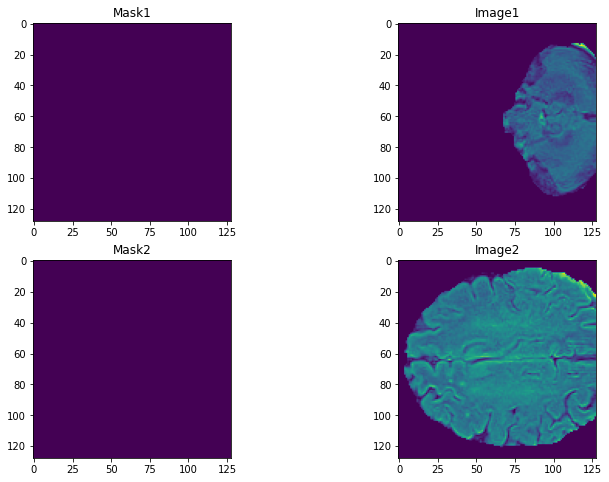

In [ ]:
rand=np.random.randint(0,26880 )
rand_2=np.random.randint(0,26880)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Mask1')
plt.imshow(x_train[rand,:,:])
plt.subplot(222)
plt.title('Image1')
plt.imshow(y_train[rand,:,:])

plt.subplot(223)
plt.title('Mask2')
plt.imshow(x_train[rand_2,:,:])
plt.subplot(224)
plt.title('Image2')
plt.imshow(y_train[rand_2,:,:])

plt.imshow

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization
#from keras import layers
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20)

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((21504, 128, 128), (5376, 128, 128), (21504, 128, 128), (5376, 128, 128))

In [ ]:
import random

<function matplotlib.pyplot.imshow>

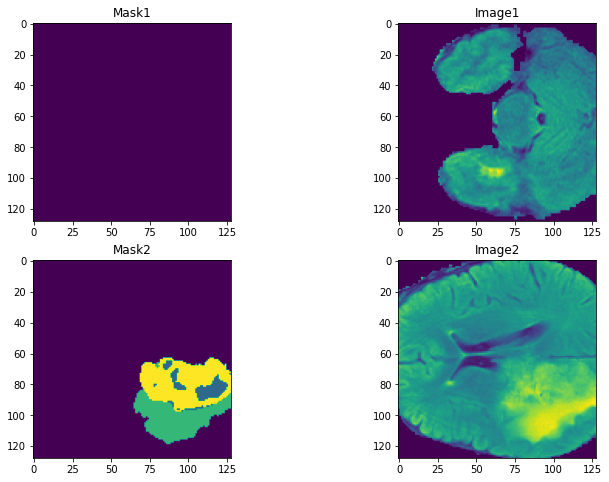

In [ ]:
rand=np.random.randint(0,21504 )
rand_2=np.random.randint(0,5376)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Mask1')
plt.imshow(x_train[rand,:,:])
plt.subplot(222)
plt.title('Image1')
plt.imshow(y_train[rand,:,:])

plt.subplot(223)
plt.title('Mask2')
plt.imshow(x_val[rand_2,:,:])
plt.subplot(224)
plt.title('Image2')
plt.imshow(y_val[rand_2,:,:])

plt.imshow

In [ ]:
x_train = tf.keras.utils.to_categorical(x_train)
x_val = tf.keras.utils.to_categorical(x_val)

In [ ]:
y_train = np.expand_dims(y_train, axis = 3)
y_val = np.expand_dims(y_val, axis = 3)

In [ ]:
del mask2D, image2D

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((21504, 128, 128, 4),
 (5376, 128, 128, 4),
 (21504, 128, 128, 1),
 (5376, 128, 128, 1))

In [ ]:
def load_batch(batch_size=1):

  for i in range(0, len(x_train), batch_size):
    img_B = x_train[i:i+batch_size,:,:,:]
    img_A = y_train[i:i+batch_size,:,:,:]
    
    yield img_A, img_B
    #return img_A, img_B


In [ ]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input]) #skip connection
            return u

        
        d0 = Input(shape=mask_shape)

        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, gf*8)
        u2 = deconv2d(u1, d5, gf*8)
        u3 = deconv2d(u2, d4, gf*8)
        u4 = deconv2d(u3, d3, gf*4)
        u5 = deconv2d(u4, d2, gf*2)
        u6 = deconv2d(u5, d1, gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(channels_img, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

In [ ]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=mask_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

In [ ]:
img_rows = 128
img_cols = 128
channels_img = 1
channels_msk = 4
img_shape = (img_rows, img_cols, channels_img)
mask_shape = (img_rows, img_cols, channels_msk) 


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(learning_rate = 0.0002)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=mask_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer, run_eagerly=True)

In [ ]:
from tensorflow.keras.utils import plot_model

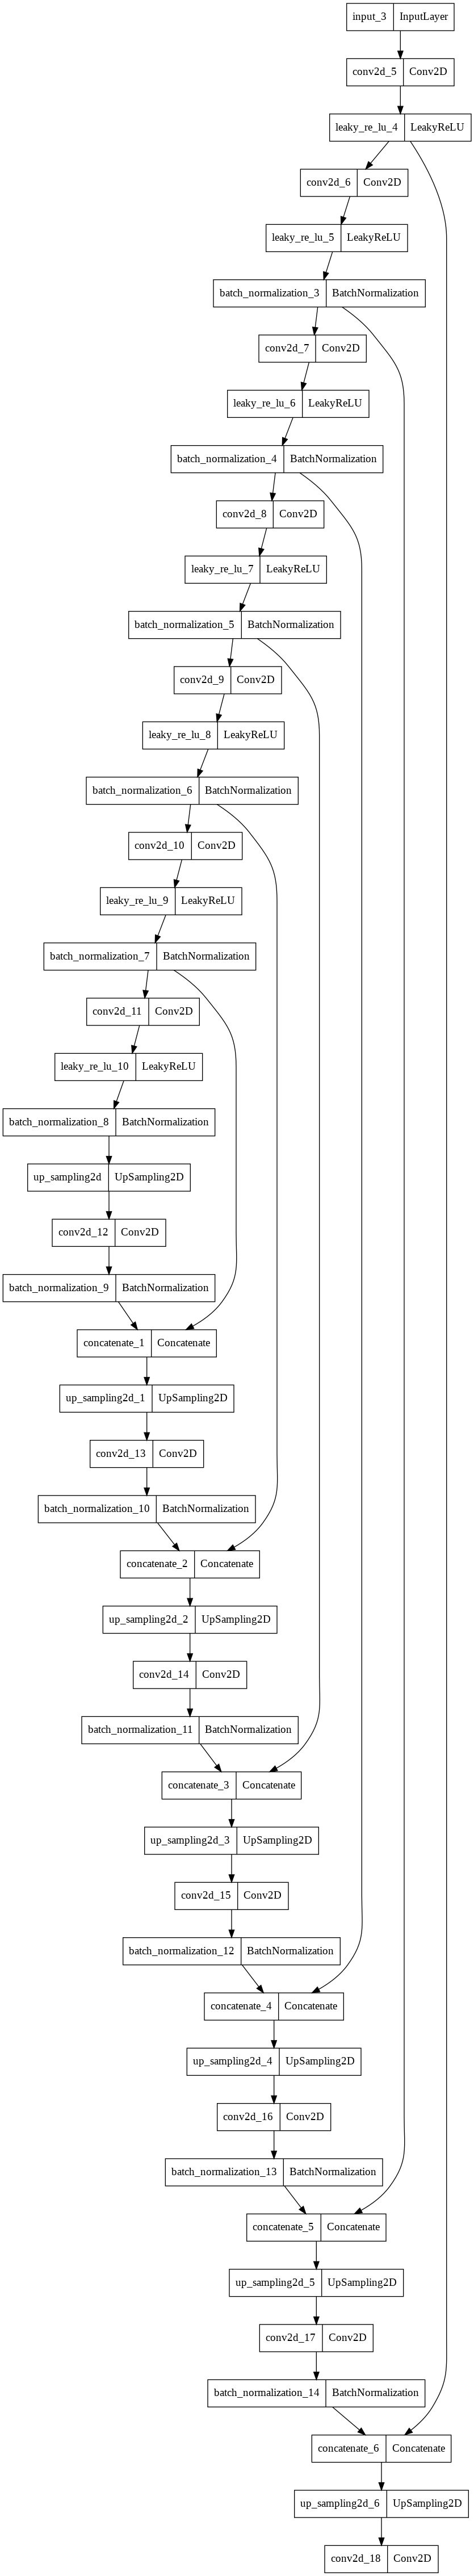

In [ ]:
plot_model(generator, to_file='/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa_data/Report/fig_for_reports/CGAN_generator.png')

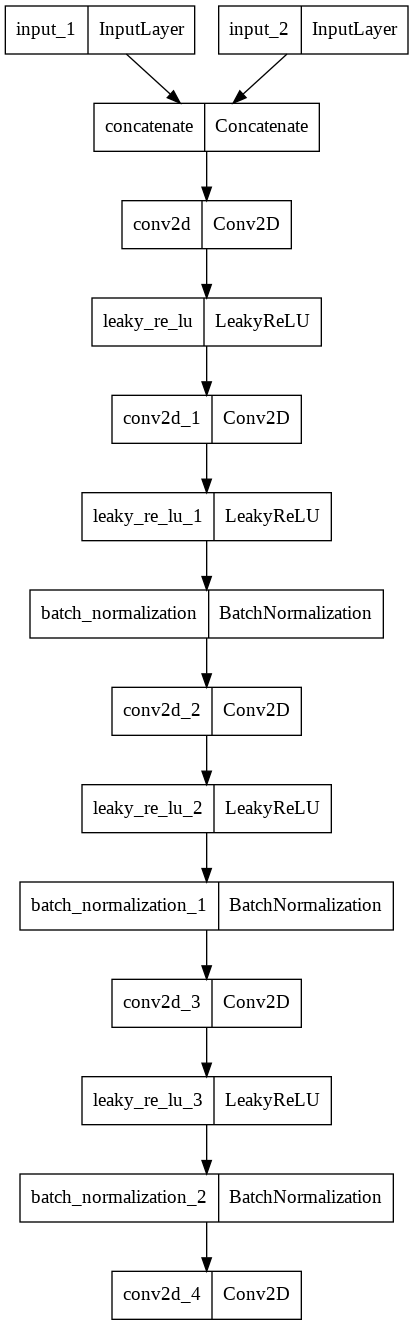

In [ ]:
plot_model(discriminator, to_file='/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa_data/Report/fig_for_reports/CGAN+discriminator.png')

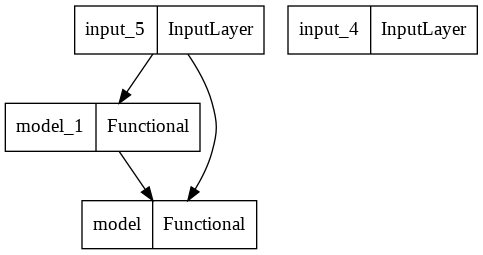

In [ ]:

plot_model(combined, to_file='/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa_data/Report/fig_for_reports/CGAN_combined.png')

In [ ]:
tf.keras.utils.plot_model(
    combined.build_graph(),                      # here is the trick (for now)
    #to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

AttributeError: ignored

In [ ]:
combined.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 128, 128, 1)  41840257    ['input_10[0][0]']               
                                                                                                  
 input_9 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                            

In [ ]:
def show_images(batch_i):
        
        r, c = 3, 3

        batch_i = 3

        rand_ = random.randint(0,(len(x_val)-batch_i))

        imgs_B, imgs_A = x_val[rand_:rand_+batch_i,:,:,:], y_val[rand_:rand_+batch_i,:,:,:]
        fake_A = generator.predict(imgs_B)
        x_ = np.argmax(imgs_B, axis = 3)
        x = x_[:,:,:]
        y = fake_A[:,:,:,0]
        z = imgs_A[:,:,:,0]
        
        gen_imgs = np.concatenate([x, y, z])

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        plt.figure(figsize=(12, 8))
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [ ]:
def train(epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(batch_size)):

                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                
            # Plot the progress
            #if epoch%10==0:
            print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                    d_loss[0], 100*d_loss[1],
                                                                    g_loss[0],
                                                                    elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(batch_i)

In [ ]:
import numpy as np

In [ ]:
valid = np.ones((64,) + (8,8,1))
valid.shape

(64, 8, 8, 1)

[Epoch 0/100]  [D loss: 0.021180, acc:  99%] [G loss: 15.024583] time: 0:04:11.663833


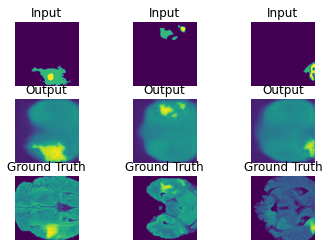

<Figure size 864x576 with 0 Axes>

[Epoch 1/100]  [D loss: 0.017367, acc:  99%] [G loss: 13.198256] time: 0:08:14.566715


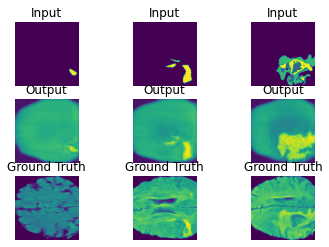

<Figure size 864x576 with 0 Axes>

[Epoch 2/100]  [D loss: 0.015739, acc:  99%] [G loss: 12.418292] time: 0:12:14.105827


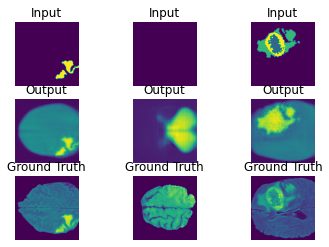

<Figure size 864x576 with 0 Axes>

[Epoch 3/100]  [D loss: 0.019454, acc:  99%] [G loss: 12.157800] time: 0:16:14.093867


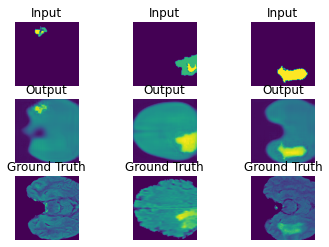

<Figure size 864x576 with 0 Axes>

[Epoch 4/100]  [D loss: 0.032949, acc:  99%] [G loss: 11.475932] time: 0:20:15.701231


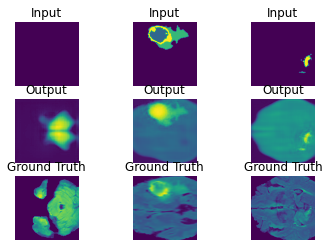

<Figure size 864x576 with 0 Axes>

[Epoch 5/100]  [D loss: 0.081915, acc:  96%] [G loss: 11.200453] time: 0:24:17.593908


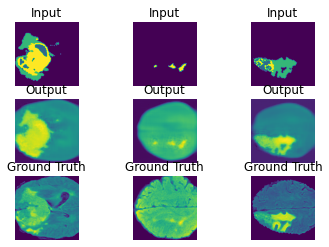

<Figure size 864x576 with 0 Axes>

[Epoch 6/100]  [D loss: 0.007224, acc:  99%] [G loss: 11.117507] time: 0:28:18.865690


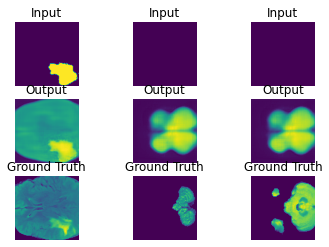

<Figure size 864x576 with 0 Axes>

[Epoch 7/100]  [D loss: 0.005089, acc:  99%] [G loss: 10.625692] time: 0:32:19.321521


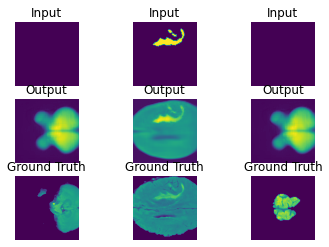

<Figure size 864x576 with 0 Axes>

[Epoch 8/100]  [D loss: 0.002391, acc: 100%] [G loss: 10.674712] time: 0:36:20.191143


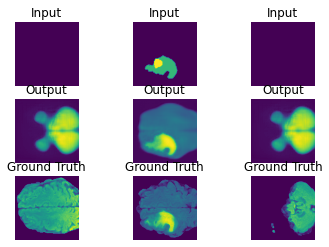

<Figure size 864x576 with 0 Axes>

[Epoch 9/100]  [D loss: 0.040099, acc:  99%] [G loss: 11.043486] time: 0:40:23.139104


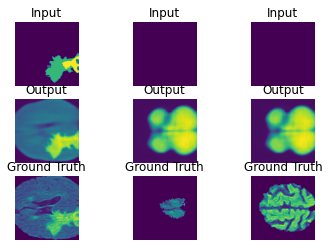

<Figure size 864x576 with 0 Axes>

[Epoch 10/100]  [D loss: 0.001924, acc: 100%] [G loss: 10.372030] time: 0:44:26.338134


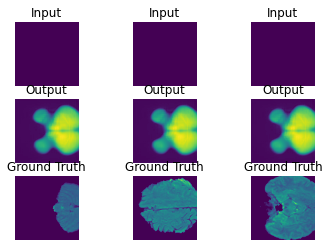

<Figure size 864x576 with 0 Axes>

[Epoch 11/100]  [D loss: 0.005854, acc: 100%] [G loss: 10.478355] time: 0:48:29.446054


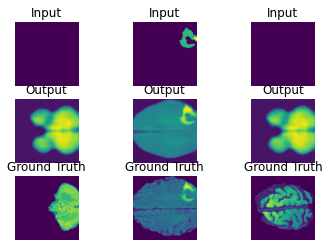

<Figure size 864x576 with 0 Axes>

[Epoch 12/100]  [D loss: 0.002592, acc: 100%] [G loss: 10.221213] time: 0:52:29.653874


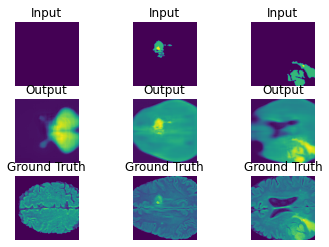

<Figure size 864x576 with 0 Axes>

[Epoch 13/100]  [D loss: 0.002399, acc: 100%] [G loss: 10.158169] time: 0:56:29.803053


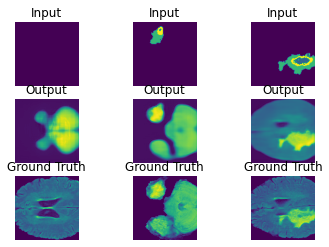

<Figure size 864x576 with 0 Axes>

[Epoch 14/100]  [D loss: 0.002652, acc: 100%] [G loss: 9.901509] time: 1:00:31.152162


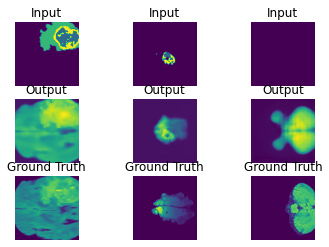

<Figure size 864x576 with 0 Axes>

[Epoch 15/100]  [D loss: 0.003299, acc: 100%] [G loss: 9.785085] time: 1:04:31.929451


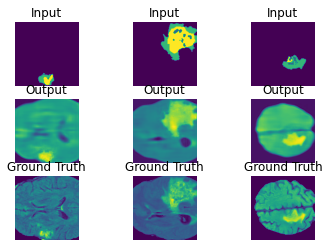

<Figure size 864x576 with 0 Axes>

[Epoch 16/100]  [D loss: 0.004241, acc: 100%] [G loss: 9.995413] time: 1:08:33.254543


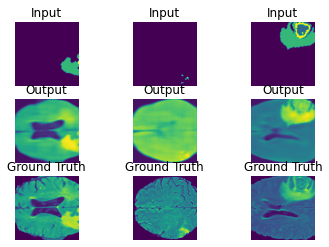

<Figure size 864x576 with 0 Axes>

[Epoch 17/100]  [D loss: 0.005330, acc: 100%] [G loss: 9.861743] time: 1:12:36.487241


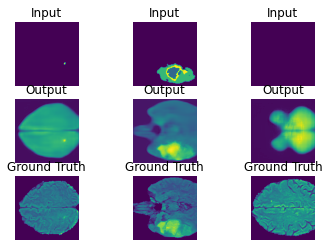

<Figure size 864x576 with 0 Axes>

[Epoch 18/100]  [D loss: 0.001490, acc:  99%] [G loss: 9.708419] time: 1:16:37.589304


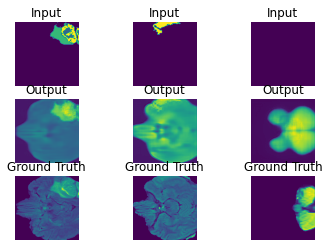

<Figure size 864x576 with 0 Axes>

[Epoch 19/100]  [D loss: 0.002836, acc:  99%] [G loss: 9.767122] time: 1:20:36.835218


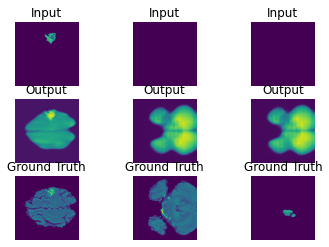

<Figure size 864x576 with 0 Axes>

[Epoch 20/100]  [D loss: 0.005686, acc:  99%] [G loss: 9.673652] time: 1:24:38.264659


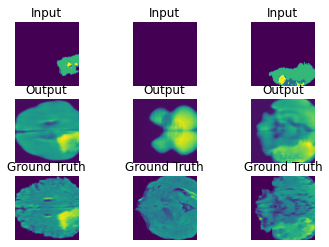

<Figure size 864x576 with 0 Axes>

[Epoch 21/100]  [D loss: 0.001928, acc:  99%] [G loss: 9.533741] time: 1:28:38.690050


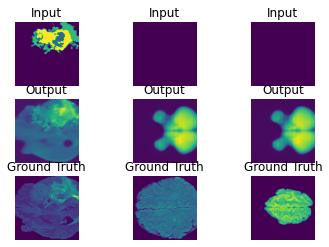

<Figure size 864x576 with 0 Axes>

[Epoch 22/100]  [D loss: 0.000656, acc: 100%] [G loss: 9.532604] time: 1:32:37.818150


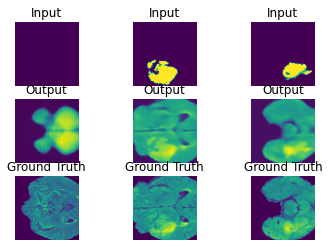

<Figure size 864x576 with 0 Axes>

[Epoch 23/100]  [D loss: 0.001347, acc: 100%] [G loss: 9.416506] time: 1:36:36.979164


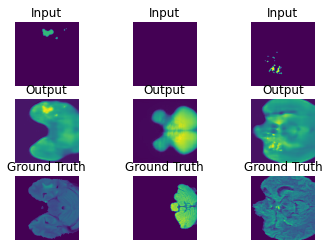

<Figure size 864x576 with 0 Axes>

[Epoch 24/100]  [D loss: 0.001873, acc: 100%] [G loss: 9.451159] time: 1:40:36.345800


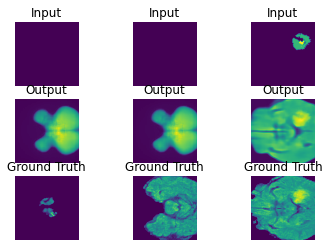

<Figure size 864x576 with 0 Axes>

[Epoch 25/100]  [D loss: 0.001935, acc: 100%] [G loss: 9.691423] time: 1:44:35.542106


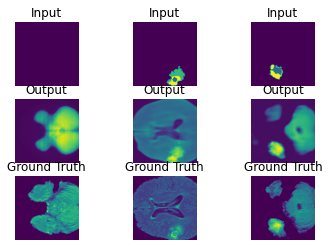

<Figure size 864x576 with 0 Axes>

[Epoch 26/100]  [D loss: 0.002284, acc:  99%] [G loss: 9.618871] time: 1:48:35.366731


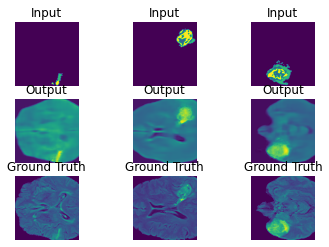

<Figure size 864x576 with 0 Axes>

[Epoch 27/100]  [D loss: 0.003090, acc:  99%] [G loss: 9.629041] time: 1:52:33.826300


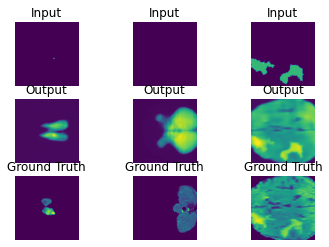

<Figure size 864x576 with 0 Axes>

[Epoch 28/100]  [D loss: 0.001487, acc:  99%] [G loss: 9.465863] time: 1:56:33.746449


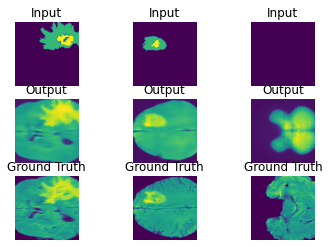

<Figure size 864x576 with 0 Axes>

[Epoch 29/100]  [D loss: 0.002700, acc:  99%] [G loss: 9.411072] time: 2:00:32.628850


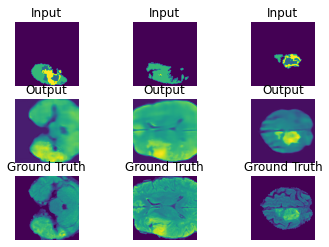

<Figure size 864x576 with 0 Axes>

[Epoch 30/100]  [D loss: 0.004268, acc:  99%] [G loss: 9.370690] time: 2:04:32.199383


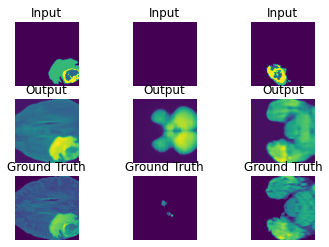

<Figure size 864x576 with 0 Axes>

[Epoch 31/100]  [D loss: 0.001726, acc:  99%] [G loss: 9.621496] time: 2:08:31.620629


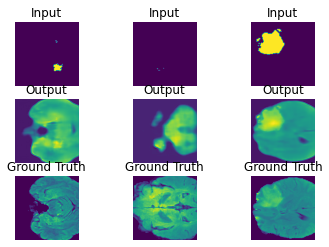

<Figure size 864x576 with 0 Axes>

[Epoch 32/100]  [D loss: 0.001055, acc: 100%] [G loss: 9.550842] time: 2:12:31.343109


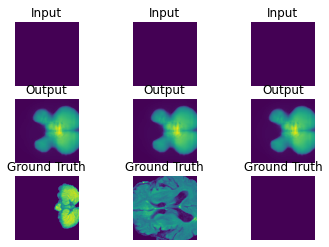

<Figure size 864x576 with 0 Axes>

[Epoch 33/100]  [D loss: 0.001028, acc:  99%] [G loss: 9.237594] time: 2:16:32.613116


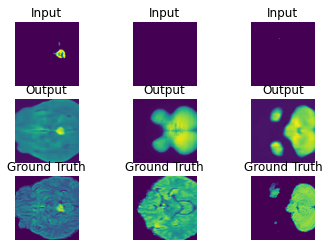

<Figure size 864x576 with 0 Axes>

[Epoch 34/100]  [D loss: 0.002723, acc: 100%] [G loss: 9.194561] time: 2:20:31.688285


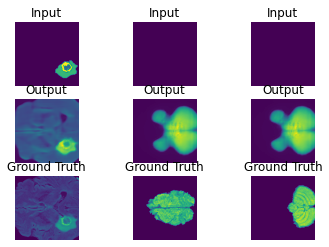

<Figure size 864x576 with 0 Axes>

[Epoch 35/100]  [D loss: 0.002117, acc: 100%] [G loss: 9.250711] time: 2:24:34.209829


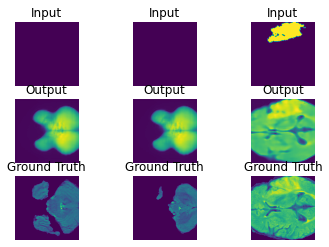

<Figure size 864x576 with 0 Axes>

[Epoch 36/100]  [D loss: 0.006299, acc:  99%] [G loss: 9.692841] time: 2:28:32.969807


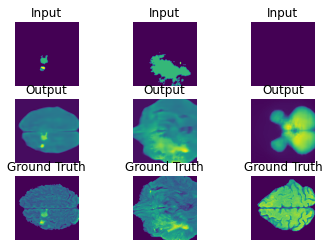

<Figure size 864x576 with 0 Axes>

[Epoch 37/100]  [D loss: 0.000869, acc: 100%] [G loss: 9.348047] time: 2:32:32.435971


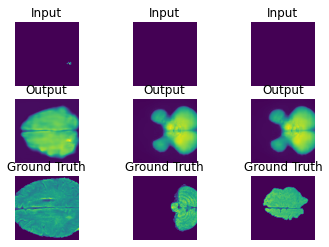

<Figure size 864x576 with 0 Axes>

[Epoch 38/100]  [D loss: 0.000888, acc: 100%] [G loss: 9.257595] time: 2:36:34.120847


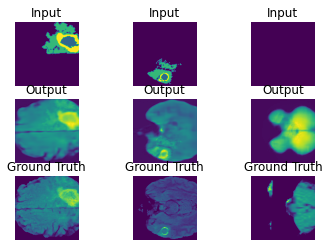

<Figure size 864x576 with 0 Axes>

[Epoch 39/100]  [D loss: 0.000559, acc: 100%] [G loss: 9.281513] time: 2:40:33.813327


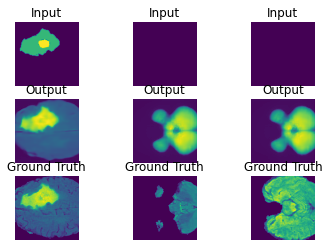

<Figure size 864x576 with 0 Axes>

[Epoch 40/100]  [D loss: 0.000783, acc: 100%] [G loss: 9.135215] time: 2:44:33.364111


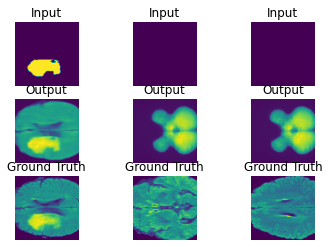

<Figure size 864x576 with 0 Axes>

[Epoch 41/100]  [D loss: 0.001221, acc: 100%] [G loss: 9.482127] time: 2:48:32.744660


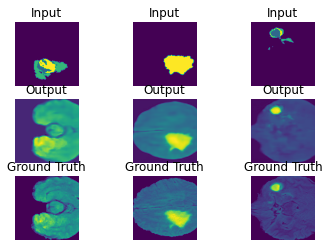

<Figure size 864x576 with 0 Axes>

[Epoch 42/100]  [D loss: 0.000983, acc: 100%] [G loss: 9.210554] time: 2:52:33.703201


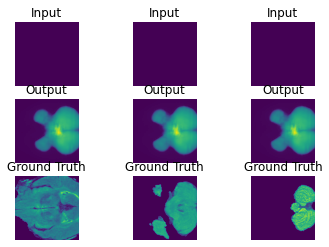

<Figure size 864x576 with 0 Axes>

[Epoch 43/100]  [D loss: 0.001734, acc: 100%] [G loss: 9.138490] time: 2:56:33.774792


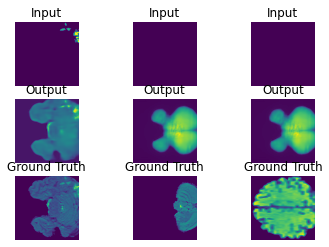

<Figure size 864x576 with 0 Axes>

[Epoch 44/100]  [D loss: 0.004081, acc: 100%] [G loss: 9.237788] time: 3:00:33.236881


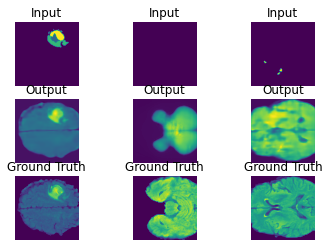

<Figure size 864x576 with 0 Axes>

[Epoch 45/100]  [D loss: 0.004808, acc:  99%] [G loss: 9.168747] time: 3:04:32.896515


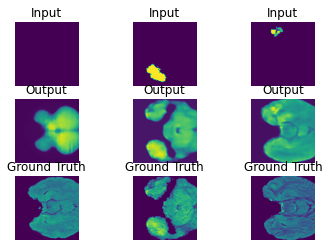

<Figure size 864x576 with 0 Axes>

[Epoch 46/100]  [D loss: 0.001419, acc: 100%] [G loss: 9.290936] time: 3:08:31.982375


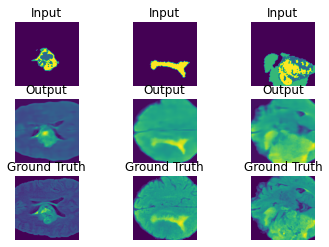

<Figure size 864x576 with 0 Axes>

[Epoch 47/100]  [D loss: 0.000729, acc: 100%] [G loss: 9.034518] time: 3:12:30.908543


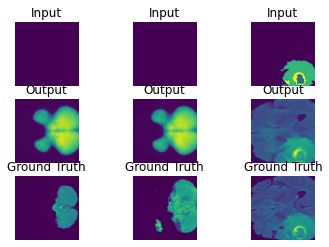

<Figure size 864x576 with 0 Axes>

[Epoch 48/100]  [D loss: 0.001436, acc:  99%] [G loss: 9.231104] time: 3:16:30.333313


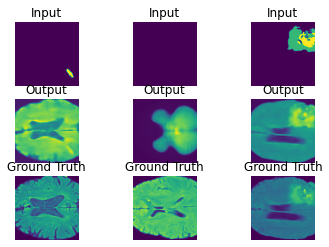

<Figure size 864x576 with 0 Axes>

[Epoch 49/100]  [D loss: 0.000566, acc: 100%] [G loss: 9.198657] time: 3:20:30.964144


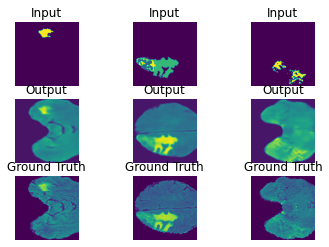

<Figure size 864x576 with 0 Axes>

[Epoch 50/100]  [D loss: 0.001010, acc: 100%] [G loss: 9.056889] time: 3:24:31.925781


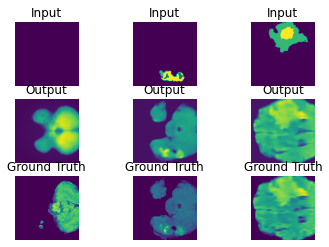

<Figure size 864x576 with 0 Axes>

[Epoch 51/100]  [D loss: 0.003620, acc:  99%] [G loss: 9.358541] time: 3:28:32.980737


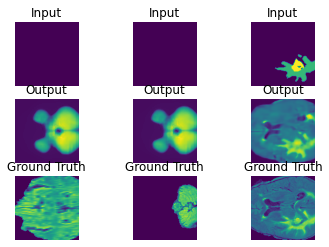

<Figure size 864x576 with 0 Axes>

[Epoch 52/100]  [D loss: 0.001157, acc: 100%] [G loss: 9.191463] time: 3:32:33.041862


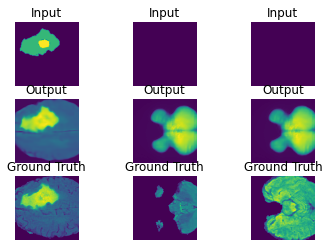

<Figure size 864x576 with 0 Axes>

[Epoch 53/100]  [D loss: 0.000651, acc: 100%] [G loss: 9.052743] time: 3:36:34.071591


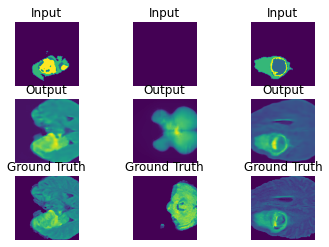

<Figure size 864x576 with 0 Axes>

[Epoch 54/100]  [D loss: 0.000976, acc:  99%] [G loss: 9.095034] time: 3:40:34.203743


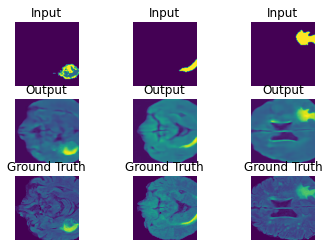

<Figure size 864x576 with 0 Axes>

[Epoch 55/100]  [D loss: 0.001148, acc:  99%] [G loss: 9.044228] time: 3:44:35.090874


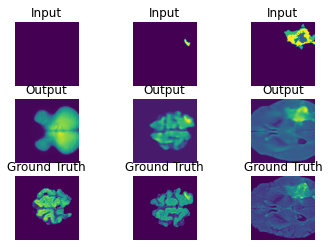

<Figure size 864x576 with 0 Axes>

[Epoch 56/100]  [D loss: 0.002375, acc:  99%] [G loss: 8.972737] time: 3:48:35.828899


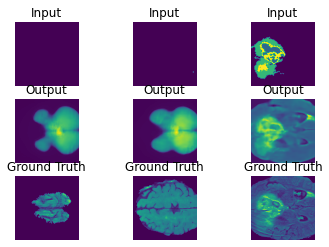

<Figure size 864x576 with 0 Axes>

[Epoch 57/100]  [D loss: 0.001570, acc: 100%] [G loss: 9.022346] time: 3:52:35.916062


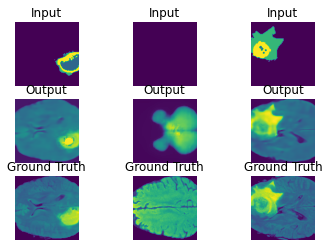

<Figure size 864x576 with 0 Axes>

[Epoch 58/100]  [D loss: 0.000893, acc: 100%] [G loss: 9.155722] time: 3:56:36.645791


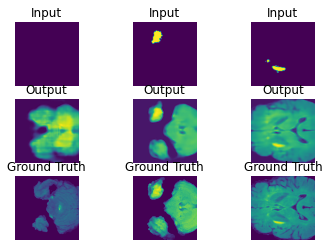

<Figure size 864x576 with 0 Axes>

[Epoch 59/100]  [D loss: 0.000917, acc: 100%] [G loss: 9.028660] time: 4:00:37.065156


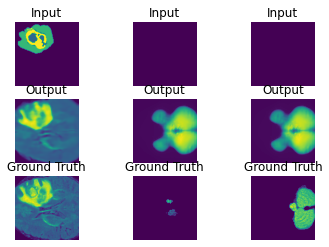

<Figure size 864x576 with 0 Axes>

[Epoch 60/100]  [D loss: 0.001359, acc: 100%] [G loss: 8.971704] time: 4:04:36.538011


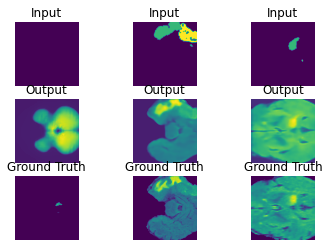

<Figure size 864x576 with 0 Axes>

[Epoch 61/100]  [D loss: 0.002790, acc:  99%] [G loss: 9.595076] time: 4:08:37.110270


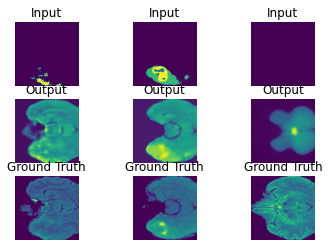

<Figure size 864x576 with 0 Axes>

[Epoch 62/100]  [D loss: 0.000811, acc: 100%] [G loss: 9.363044] time: 4:12:39.858188


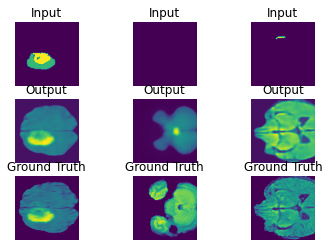

<Figure size 864x576 with 0 Axes>

[Epoch 63/100]  [D loss: 0.000998, acc: 100%] [G loss: 9.130332] time: 4:16:40.182048


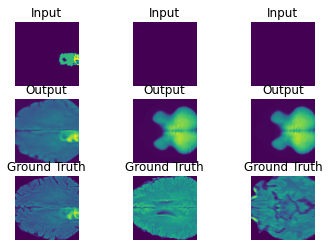

<Figure size 864x576 with 0 Axes>

[Epoch 64/100]  [D loss: 0.001304, acc: 100%] [G loss: 9.443233] time: 4:20:40.819974


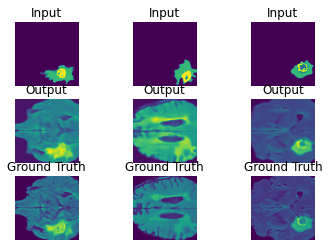

<Figure size 864x576 with 0 Axes>

[Epoch 65/100]  [D loss: 0.004054, acc:  99%] [G loss: 8.959236] time: 4:24:39.987837


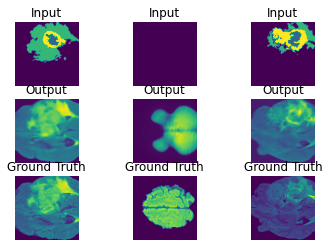

<Figure size 864x576 with 0 Axes>

[Epoch 66/100]  [D loss: 0.008208, acc:  99%] [G loss: 9.066531] time: 4:28:39.701536


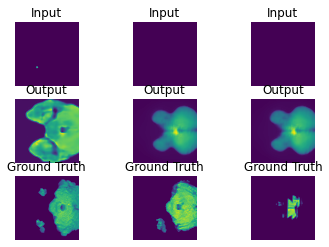

<Figure size 864x576 with 0 Axes>

[Epoch 67/100]  [D loss: 0.001287, acc: 100%] [G loss: 9.411050] time: 4:32:40.482547


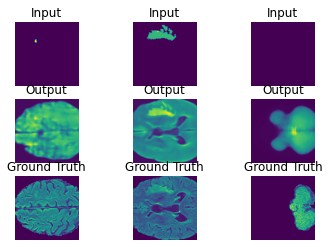

<Figure size 864x576 with 0 Axes>

[Epoch 68/100]  [D loss: 0.001820, acc: 100%] [G loss: 9.227402] time: 4:36:39.824737


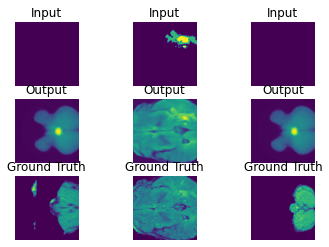

<Figure size 864x576 with 0 Axes>

[Epoch 69/100]  [D loss: 0.000510, acc: 100%] [G loss: 9.164237] time: 4:40:37.440314


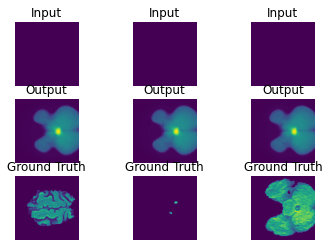

<Figure size 864x576 with 0 Axes>

[Epoch 70/100]  [D loss: 0.000371, acc: 100%] [G loss: 9.076084] time: 4:44:36.296283


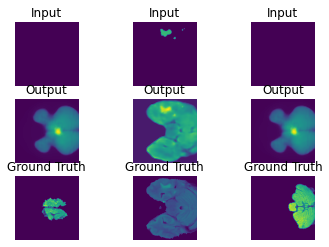

<Figure size 864x576 with 0 Axes>

[Epoch 71/100]  [D loss: 0.000557, acc: 100%] [G loss: 9.064511] time: 4:48:33.864174


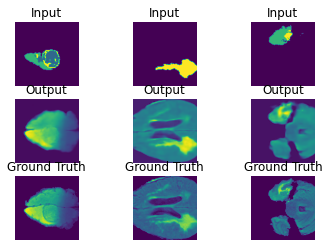

<Figure size 864x576 with 0 Axes>

[Epoch 72/100]  [D loss: 0.000470, acc: 100%] [G loss: 8.967727] time: 4:52:33.866521


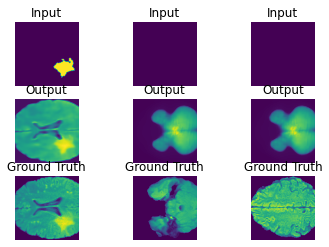

<Figure size 864x576 with 0 Axes>

[Epoch 73/100]  [D loss: 0.008709, acc:  99%] [G loss: 10.207678] time: 4:56:34.715596


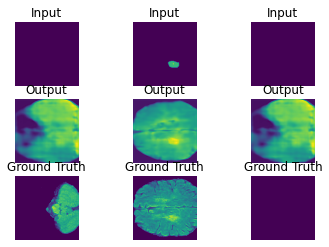

<Figure size 864x576 with 0 Axes>

[Epoch 74/100]  [D loss: 0.000316, acc: 100%] [G loss: 9.415904] time: 5:00:34.346749


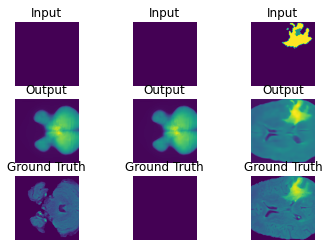

<Figure size 864x576 with 0 Axes>

[Epoch 75/100]  [D loss: 0.001224, acc: 100%] [G loss: 9.125272] time: 5:04:32.212292


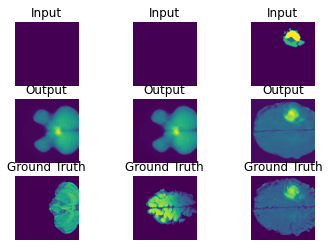

<Figure size 864x576 with 0 Axes>

[Epoch 76/100]  [D loss: 0.007524, acc:  99%] [G loss: 8.967443] time: 5:08:32.624713


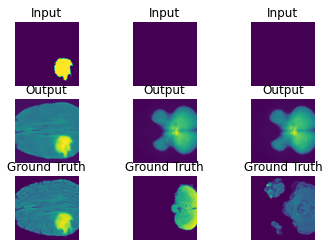

<Figure size 864x576 with 0 Axes>

[Epoch 77/100]  [D loss: 0.001057, acc:  99%] [G loss: 9.000068] time: 5:12:32.616315


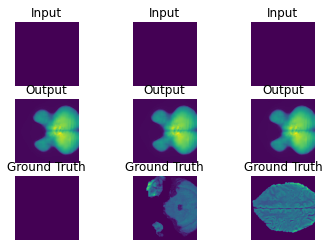

<Figure size 864x576 with 0 Axes>

[Epoch 78/100]  [D loss: 0.000441, acc: 100%] [G loss: 8.886208] time: 5:16:32.554785


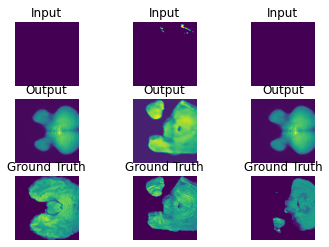

<Figure size 864x576 with 0 Axes>

[Epoch 79/100]  [D loss: 0.000779, acc: 100%] [G loss: 9.302834] time: 5:20:34.890347


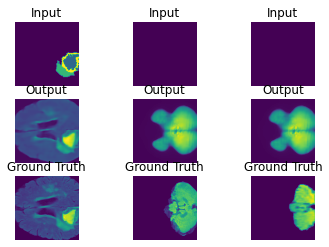

<Figure size 864x576 with 0 Axes>

[Epoch 80/100]  [D loss: 0.000544, acc: 100%] [G loss: 9.146232] time: 5:24:35.214246


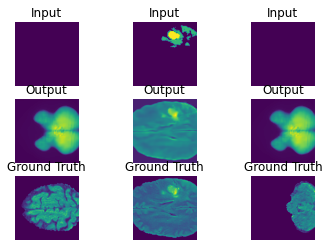

<Figure size 864x576 with 0 Axes>

[Epoch 81/100]  [D loss: 0.000825, acc: 100%] [G loss: 8.982490] time: 5:28:35.424751


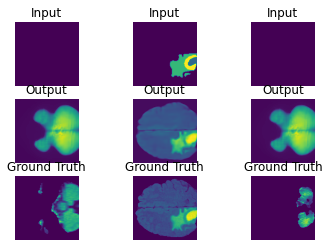

<Figure size 864x576 with 0 Axes>

[Epoch 82/100]  [D loss: 0.000203, acc: 100%] [G loss: 8.895804] time: 5:32:35.654766


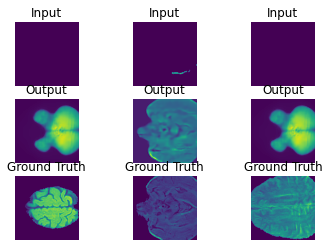

<Figure size 864x576 with 0 Axes>

[Epoch 83/100]  [D loss: 0.000381, acc: 100%] [G loss: 9.071925] time: 5:36:35.691042


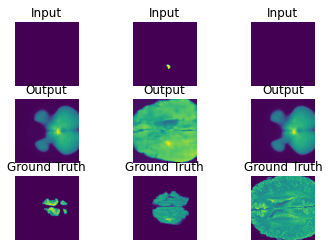

<Figure size 864x576 with 0 Axes>

[Epoch 84/100]  [D loss: 0.000145, acc: 100%] [G loss: 8.966479] time: 5:40:35.875458


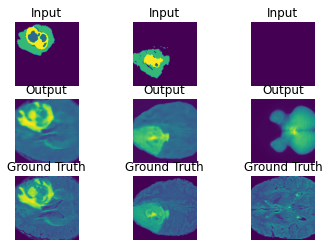

<Figure size 864x576 with 0 Axes>

[Epoch 85/100]  [D loss: 0.000210, acc: 100%] [G loss: 8.910511] time: 5:44:37.335940


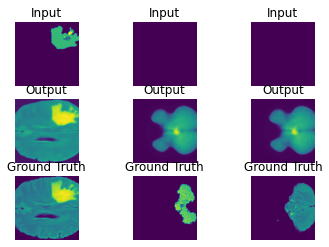

<Figure size 864x576 with 0 Axes>

[Epoch 86/100]  [D loss: 0.001075, acc: 100%] [G loss: 8.989110] time: 5:48:36.220220


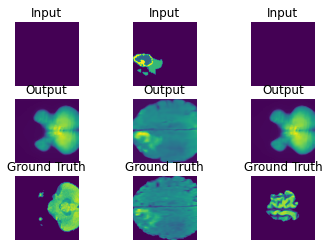

<Figure size 864x576 with 0 Axes>

[Epoch 87/100]  [D loss: 0.000437, acc: 100%] [G loss: 9.248135] time: 5:52:34.646759


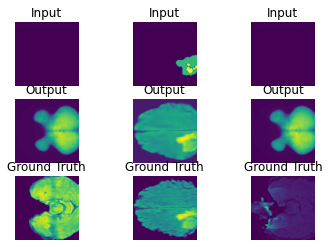

<Figure size 864x576 with 0 Axes>

[Epoch 88/100]  [D loss: 0.000252, acc: 100%] [G loss: 9.214844] time: 5:56:35.419610


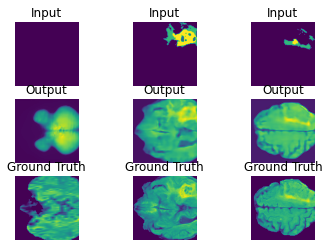

<Figure size 864x576 with 0 Axes>

[Epoch 89/100]  [D loss: 0.000455, acc: 100%] [G loss: 8.956052] time: 6:00:36.431685


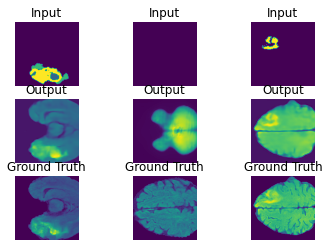

<Figure size 864x576 with 0 Axes>

[Epoch 90/100]  [D loss: 0.000213, acc: 100%] [G loss: 9.328130] time: 6:04:35.197786


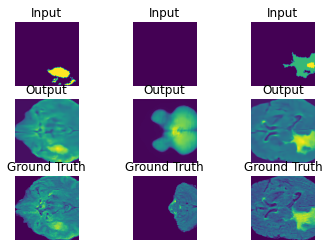

<Figure size 864x576 with 0 Axes>

[Epoch 91/100]  [D loss: 0.000219, acc: 100%] [G loss: 9.059434] time: 6:08:33.484998


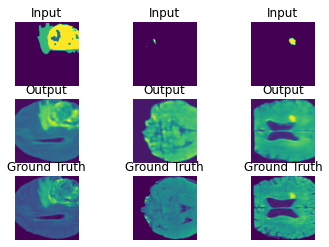

<Figure size 864x576 with 0 Axes>

[Epoch 92/100]  [D loss: 0.000215, acc: 100%] [G loss: 9.095281] time: 6:12:34.586845


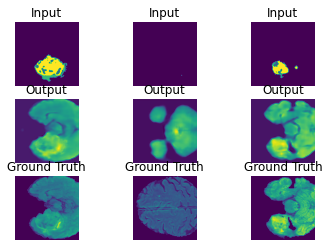

<Figure size 864x576 with 0 Axes>

[Epoch 93/100]  [D loss: 0.003582, acc: 100%] [G loss: 8.974372] time: 6:16:32.676605


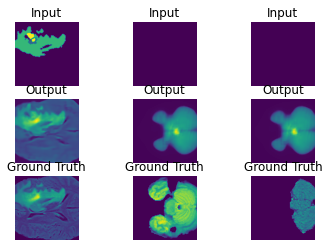

<Figure size 864x576 with 0 Axes>

[Epoch 94/100]  [D loss: 0.000701, acc: 100%] [G loss: 8.955269] time: 6:20:32.629226


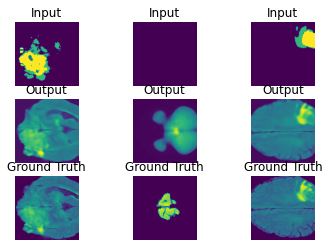

<Figure size 864x576 with 0 Axes>

[Epoch 95/100]  [D loss: 0.000797, acc: 100%] [G loss: 9.129544] time: 6:24:31.494364


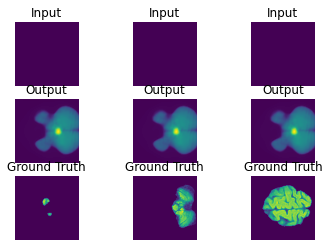

<Figure size 864x576 with 0 Axes>

[Epoch 96/100]  [D loss: 0.000651, acc: 100%] [G loss: 8.889904] time: 6:28:30.068200


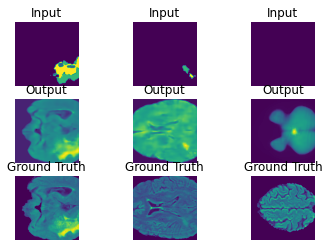

<Figure size 864x576 with 0 Axes>

[Epoch 97/100]  [D loss: 0.000438, acc: 100%] [G loss: 9.019078] time: 6:32:34.943191


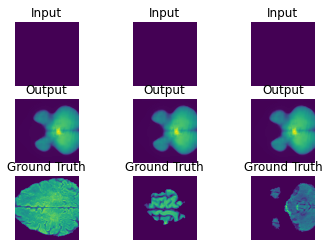

<Figure size 864x576 with 0 Axes>

[Epoch 98/100]  [D loss: 0.000379, acc: 100%] [G loss: 8.996269] time: 6:36:35.688715


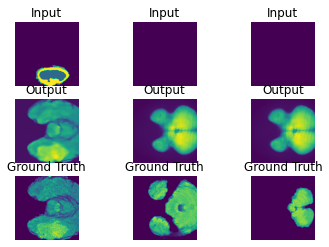

<Figure size 864x576 with 0 Axes>

[Epoch 99/100]  [D loss: 0.000254, acc: 100%] [G loss: 8.911694] time: 6:40:36.013288


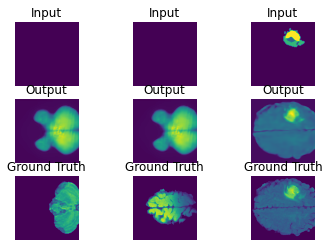

<Figure size 864x576 with 0 Axes>

In [ ]:
train(epochs=100, batch_size=64, show_interval=1)

In [ ]:
combined.save('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa data/Models/C_Gans_combined_model/CGAN_model_combined.h5')

In [ ]:
discriminator.save('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa data/Models/C_Gans_Discriminator/CGAN_model_discriminator.h5')

In [ ]:
generator.save('/content/drive/MyDrive/Brain_tumor_Segmentation/huzaifa data/Models/C_Gans_Generator/CGAN_model_generator.h5')